In [14]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from mlxtend.data import loadlocal_mnist
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [15]:
train_images,train_labels=loadlocal_mnist(images_path='D:/Downloads/MNIST/raw/train-images-idx3-ubyte', labels_path='D:/Downloads/MNIST/raw/train-labels-idx1-ubyte')
test_images,test_labels=loadlocal_mnist(images_path='D:/Downloads/MNIST/raw/t10k-images-idx3-ubyte', labels_path='D:/Downloads/MNIST/raw/t10k-labels-idx1-ubyte')


In [ ]:
# train_images,train_labels=loadlocal_mnist(images_path='D:/Downloads/MNIST/raw/train-images-idx3-ubyte', labels_path='D:/Downloads/MNIST/raw/train-labels-idx1-ubyte')
# test_images,test_labels=loadlocal_mnist(images_path='D:/Downloads/MNIST/raw/t10k-images-idx3-ubyte', labels_path='D:/Downloads/MNIST/raw/t10k-labels-idx1-ubyte')

# np.save('train_images',train_images)
# np.save('train_labels',train_labels)
# np.save('test_images',test_images)
# np.save('test_labels',test_labels)

# train_df=train_df.to_numpy()
# test_df=test_df.to_numpy()
# train_images = train_df[:, 1:]/255
# test_images = test_df[:, 1:]/255
# train_labels = train_df[:, 0]
# test_labels = test_df[:, 0]


In [16]:

#pre processing
standardscalar = StandardScaler()

train_images = standardscalar.fit_transform(train_images)
test_images = standardscalar.transform(test_images)

data=[]
labels=[]
for i in range(len(train_images)):
    data.append(train_images[i])
    labels.append(train_labels[i])
for i in range(len(test_images)):
    data.append(test_images[i])
    labels.append(test_labels[i])

data=np.array(data)
labels=np.array(labels)

#random shuffling
data,labels=shuffle(data,labels)

#dividing by max value to convert every pixel to 0-1
data=data/255


In [17]:
data.shape

(70000, 784)

In [18]:
def train_val_test_split(data,labels, train,val,test):
    """ a function that will get dataset and training dataset fraction as input and return x_train, x_test, y_train, y_test """
    
    print("Total length is "+str(len(data)))
    
    train_samples=len(data)*train//(train+test+val)
    val_samples=len(data)*val//(train+test+val)
    
    train_data=data[:train_samples]
    train_labels=labels[:train_samples]
    
    val_data=data[train_samples+1:train_samples+val_samples+1]
    val_labels=labels[train_samples+1:train_samples+val_samples+1]
    
    test_data=data[train_samples+val_samples:]
    test_labels=labels[train_samples+val_samples:]
    
    return train_data,train_labels,val_data,val_labels,test_data,test_labels

In [19]:
x_train,y_train,x_val,y_val,x_test,y_test=train_val_test_split(data,labels,7,2,1)

Total length is 70000


In [68]:
class MyNeuralNetwork():
    activations = ['relu','leaky_relu', 'sigmoid', 'linear', 'tanh', 'softmax']
    weight_initializations = ['zero', 'random', 'normal']
    
    def __init__(self, n_layers, layer_sizes, activation, lr, weight_initialization, batch_size, epochs):
        self.n_layers = n_layers
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.lr = lr
        self.weight_initialization = weight_initialization
        self.batch_size = batch_size
        self.epochs = epochs
        self.W,self.B=self.initialize_weights()  #Weight and Bias dictionary respectively
        self.A={}   #Activation values
        self.Z={}   #Pre activation values
        self.W_grad,self.B_grad=self.initialize_weights()
        self.A_grad={}
        self.Z_grad={}
        self.train_loss=[]
        self.train_epochs=[]
        self.val_epochs=[]
        self.val_loss=[]
        
    def activate(self, arr, name, grad=False):
        if(name=='relu'):
            if(not grad):
                arr[arr<0]=0
                
            else:
                arr[arr<0]=0
                arr[arr>0]=1
                
        elif(name=='leaky_relu'):
            if(not grad):
                for i in arr:
                    if(i<0):
                        i=i*0.01
            else:
                arr[arr<0]=0.01
                
        elif(name=='sigmoid'):
            if(not grad):
                arr=1/(1+np.exp(-arr))
                
            else:
                x=self.activate(arr,'sigmoid')
                arr=x*(1-x)
        
        elif(name=='linear'):
            if(grad):
                arr=np.ones(arr.shape)
                
        elif(name=='tanh'):
            if(not grad):
                arr=np.tanh(arr)
            
            else:
                y=np.tanh(arr)
                arr=1-y*y
                
        else:
            #softmax derivative is a jacobian matrix
            y = np.exp(arr)
            arr= y/(np.sum(y,axis = 1, keepdims = True))
            
        
        mini=1e-20
        maxi=1e20
        arr[arr<mini]=0
        arr[arr>maxi]=maxi
        return arr

    def initialization(self, name, shape):
        x=np.zeros(shape)
        if(name=='random'):
            x=np.random.rand(shape[0],shape[1])*0.01
            
        elif(name=='normal'):
            x=np.random.normal(size = shape)*0.01
        
        return x
    
    def initialize_weights(self):
        Weight={}
        Bias={}
        
        for i in range(self.n_layers-1):
            Weight[i+1]=self.initialization(self.weight_initialization, (self.layer_sizes[i],self.layer_sizes[i+1]))
            Bias[i+1]=self.initialization(self.weight_initialization, (1,self.layer_sizes[i+1]))    
        
        return Weight,Bias
    
    def fit(self,x_train,y_train,x_val=None,y_val=None):
        val_flag=False
        if(x_val is not None):
            val_flag=True
            val_labels_vector=np.zeros((len(x_val),10))
            for i in range(len(x_val)):
                val_labels_vector[i][y_val[i]]=1
                
        for e in range(self.epochs):
            
            print("Epoch "+str(e))
            curr_loss=0
            curr_val_loss=0
            sample_ind=0
            self.train_epochs.append(e+1)
            times=0
            
            if(x_val is not None):
                self.val_epochs.append(e+1)
                
            while sample_ind<len(x_train):
                times+=1
                
                curr_batch=x_train[sample_ind:min(len(x_train),sample_ind+self.batch_size)]
                curr_labels=y_train[sample_ind:min(len(y_train),sample_ind+self.batch_size)]
                
                #forward prop
                self.A[0]=curr_batch
                self.forward_propagation()
                
                #loss calc
                labels_vectorized=np.zeros((len(curr_labels),10))
                for i in range(len(curr_labels)):
                    labels_vectorized[i][curr_labels[i]]=1
                
                #loss
                loss=self.cross_entropy_loss(self.A[self.n_layers-1],labels_vectorized)
                curr_loss+=loss
                
                output=self.A[self.n_layers-1]
                new_arr=output*(1-output)
                self.A_grad[self.n_layers-1]=(output-labels_vectorized)/new_arr
                
                #backward pass for all layers
                self.backward_propagation()
                    
                #weight update for all layers
                for l in range(1,self.n_layers):
                    self.W[l]=self.W[l]-self.lr*self.W_grad[l]
                    self.B[l]=self.B[l]-self.lr*self.B_grad[l]
                
                sample_ind+=self.batch_size
                
            if(x_val is not None):
                findd=self.predict_proba(x_val)
                curr_val_loss=self.cross_entropy_loss(findd,val_labels_vector)

            print("Training Loss of epoch "+str(e)+" is "+str(curr_loss/times))
            if(val_flag):
                print("Validation Loss of epoch "+str(e)+" is "+str(curr_val_loss))

            self.train_loss.append(curr_loss/times)
            if(x_val is not None):
                self.val_loss.append(curr_val_loss)
        
        self.plot_training_val(val_flag)
        
    def plot_training_val(self,val_flag):
        plt.plot(self.train_epochs,self.train_loss,'b',label='training')
        plt.plot(self.val_epochs,self.val_loss,'r',label='validation')
        plt.title("Loss vs epochs for "+self.activation+" for learning rate "+str(self.lr))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
            
    def forward_propagation(self):

        for l in range(1,self.n_layers):
            self.Z[l]=np.dot(self.A[l-1],self.W[l])
            if(l!=1):
                self.Z[l]+=self.B[l]

            self.A[l]=self.activate(self.Z[l],self.activation)
        
        #applying softmax on last layer as loss is cross entropy and we might end up taking log 0
        self.A[l]=self.activate(self.A[l],'softmax')
        
    def backward_propagation(self):

        for l in range(self.n_layers-1,0,-1):
            self.Z_grad[l]=self.activate(self.Z[l],self.activation,grad=True)*self.A_grad[l]
            assert(self.Z_grad[l].shape==self.Z[l].shape)
            self.W_grad[l]=np.dot(self.A[l-1].T,self.Z_grad[l])/len(self.A_grad[l])
            assert(self.W_grad[l].shape==self.W[l].shape)
            self.B_grad[l]=np.sum(self.Z_grad[l],axis=0)/len(self.A_grad[l])
            self.B_grad[l]=self.B_grad[l].reshape((self.B[l].shape))
            assert(self.B_grad[l].shape==self.B[l].shape)
            self.A_grad[l-1]=np.dot(self.Z_grad[l],self.W[l].T)
            assert(self.A_grad[l-1].shape==self.A[l-1].shape)
        
    def predict_proba(self, X):
        print("pred")
        preact={}
        act={}
        act[0]=X
        
        for l in range(1,self.n_layers):
            preact[l]=np.dot(act[l-1],self.W[l])
            if(l!=1):
                preact[l]+=self.B[l]
                
            act[l]=self.activate(preact[l],self.activation)
            
        ans=self.activate(act[self.n_layers-1],'softmax')
        return ans
    
    def predict(self, X):
        y=self.predict_proba(X)

        # return the numpy array y which contains the predicted values
        return y.argmax(axis=1)
    
    def cross_entropy_loss(self, A, y):
        #check for problems

        n = len(y)
        logp = - np.log(A[np.arange(n), y.argmax(axis=1)]+1e-10)
        loss = np.sum(logp+1e-10)/n
        return loss
    
    def score(self, X , y_true):
        y_pred=self.predict(X)
        
        return np.sum(y_true==y_pred)/len(y_true)

Epoch 0
pred
Training Loss of epoch 0 is 2.2020917709978667
Validation Loss of epoch 0 is 2.302570046279222
Epoch 1
pred
Training Loss of epoch 1 is 2.2795696508674146
Validation Loss of epoch 1 is 2.30258509122453
Epoch 2
pred
Training Loss of epoch 2 is 2.3025850913605073
Validation Loss of epoch 2 is 2.302585091223572
Epoch 3
pred
Training Loss of epoch 3 is 2.3025850913597212
Validation Loss of epoch 3 is 2.30258509122261
Epoch 4
pred
Training Loss of epoch 4 is 2.302585091358933
Validation Loss of epoch 4 is 2.302585091221643
Epoch 5
pred
Training Loss of epoch 5 is 2.3025850913581394
Validation Loss of epoch 5 is 2.302585091220671
Epoch 6
pred
Training Loss of epoch 6 is 2.3025850913573365
Validation Loss of epoch 6 is 2.302585091219694
Epoch 7
pred
Training Loss of epoch 7 is 2.3025850913565273
Validation Loss of epoch 7 is 2.302585091218712
Epoch 8
pred
Training Loss of epoch 8 is 2.302585091355717
Validation Loss of epoch 8 is 2.302585091217724
Epoch 9
pred
Training Loss of ep

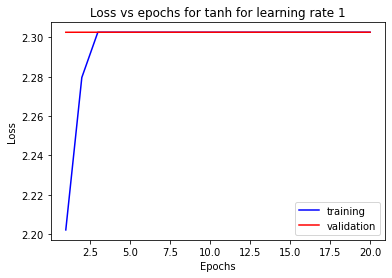

In [74]:
lrs=[1]
for i in lrs:
    net=MyNeuralNetwork(5,[784,256,128,64,10],'tanh',i,'normal',64,20)
    net.fit(train_images,train_labels,test_images,test_labels)

In [ ]:
net.fit(train_images,train_labels,test_images,test_labels)

In [63]:
net.score(test_images,test_labels)

pred


0.1135

In [64]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(256,128,64),random_state=1, max_iter=5, verbose=True).fit(train_images, train_labels)

In [8]:
clf.out_activation_

'softmax'

In [148]:
clf.score(test_images,test_labels)

0.9786

In [149]:
clf.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (256, 128, 64),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 5,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': True,
 'warm_start': False}